In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import torch
import numpy as np
import json
from tqdm import tqdm

import os
import sys
sys.path.append('..')

from relations import estimate
from util import model_utils
from dsets.counterfact import CounterFactDataset

In [65]:
MODEL_NAME = "gpt2-xl"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=False)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

In [66]:
test_cases = [
    ("The Great Wall", -1, "China"),
    ("Niagara Falls", -2, "Canada"),
    ("Valdemarsvik", -1, "Sweden"),
    ("Kyoto University", -2, "Japan"),
    ("Hattfjelldal", -1, "Norway"),
    ("Ginza", -1, "Japan"),
    ("Sydney Hospital", -2, "Australia"),
    ("Mahalangur Himal", -1, "Nepal"),
    ("Higashikagawa", -1, "Japan"),
    ("Trento", -1, "Italy"),
    ("Taj Mahal", -1, "India")
]

In [67]:
space_needle = estimate.estimate_relation_operator(
    model,
    tokenizer,
    "The Space Needle",
    "{} is located in the country of",
    layer=25,
    device=model.device,
)

In [68]:
men_park = estimate.estimate_relation_operator(
    model,
    tokenizer,
    "Menangle Park",
    "{} is located in the country of",
    subject_token_index=1,
    layer=25,
    device=model.device,
)

In [69]:
space_needle.misc, men_park.misc

({'Jh_norm': 44.985111236572266,
  'bias_norm': 372.6827087402344,
  'h_info': {'h_index': 3, 'token_id': 293, 'token': 'le'},
  'consider_residual': False},
 {'Jh_norm': 22.141036987304688,
  'bias_norm': 522.3410034179688,
  'h_info': {'h_index': 1, 'token_id': 9248, 'token': 'angle'},
  'consider_residual': False})

In [70]:
for subject, subject_token_index, target in test_cases:
    objects = men_park(
        subject,
        subject_token_index=subject_token_index,
        device=model.device,
        return_top_k=5,
    )
    print(f"{subject}, target: {target}   ==>   predicted: {objects}")

The Great Wall, target: China   ==>   predicted: [' China', ' India', ' Hong', ' the', ' Z']
Niagara Falls, target: Canada   ==>   predicted: [' Newfoundland', ' Ontario', ' New', ' Ireland', ' Canada']
Valdemarsvik, target: Sweden   ==>   predicted: [' Australia', ' New', ' the', ' Canada', ' Bh']
Kyoto University, target: Japan   ==>   predicted: [' India', ' Bh', ' Nepal', ' Thailand', ' Sri']
Hattfjelldal, target: Norway   ==>   predicted: [' Ireland', ' Scotland', ' the', ' Australia', ' Wales']
Ginza, target: Japan   ==>   predicted: [' India', ' Australia', ' Hong', ' Japan', ' Bh']
Sydney Hospital, target: Australia   ==>   predicted: [' Australia', ' Sydney', ' Queensland', ' NSW', ' New']
Mahalangur Himal, target: Nepal   ==>   predicted: [' Bh', ' Nepal', ' India', ' Sri', ' Kashmir']
Higashikagawa, target: Japan   ==>   predicted: [' Japan', ' India', ' New', ' Australia', ' the']
Trento, target: Italy   ==>   predicted: [' New', ' Australia', ' Ireland', ' the', ' France']

In [71]:
print(space_needle.bias.norm(), men_park.bias.norm())
(space_needle.bias - men_park.bias).norm()

tensor(372.6827, device='cuda:0') tensor(522.3410, device='cuda:0')


tensor(269.9868, device='cuda:0')

In [72]:
weight = torch.stack([space_needle.weight, men_park.weight]).mean(dim = 0)
bias = torch.stack([space_needle.bias, men_park.bias]).mean(dim = 0)

avg_located_in = estimate.RelationOperator(
    model = model, tokenizer= tokenizer,
    layer = 25, relation = "{} is located in the country of",
    weight= weight, 
    bias= bias
)

for subject, subject_token_index, target in test_cases:
    objects = avg_located_in(
        subject,
        subject_token_index=subject_token_index,
        device=model.device,
        return_top_k=5,
    )
    print(f"{subject}, target: {target}   ==>   predicted: {objects}")

The Great Wall, target: China   ==>   predicted: [' China', ' Hong', ' Singapore', ' Qing', ' Beijing']
Niagara Falls, target: Canada   ==>   predicted: [' Canada', ' Ontario', ' New', ' Newfoundland', ' Niagara']
Valdemarsvik, target: Sweden   ==>   predicted: [' Iceland', ' Norway', ' Sweden', ' Denmark', ' Finland']
Kyoto University, target: Japan   ==>   predicted: [' Japan', ' Nepal', ' India', ' China', ' Thailand']
Hattfjelldal, target: Norway   ==>   predicted: [' Iceland', ' Norway', ' Denmark', ' Sweden', ' Finland']
Ginza, target: Japan   ==>   predicted: [' Japan', ' Singapore', ' Hong', ' China', ' India']
Sydney Hospital, target: Australia   ==>   predicted: [' Australia', ' Sydney', ' NSW', ' Singapore', ' Australian']
Mahalangur Himal, target: Nepal   ==>   predicted: [' Nepal', ' Bh', ' Tibet', ' India', ' Nep']
Higashikagawa, target: Japan   ==>   predicted: [' Japan', ' Canada', ' Japanese', ' Tokyo', ' New']
Trento, target: Italy   ==>   predicted: [' New', ' Austra

In [73]:
wgt = space_needle.weight
svd = wgt.svd()

In [74]:
svd.U.shape, svd.S.shape, svd.V.shape

(torch.Size([1600, 1600]), torch.Size([1600]), torch.Size([1600, 1600]))

In [59]:
wgt_est = svd.U @ torch.diag(svd.S) @ svd.V.t()

torch.dist(wgt, wgt_est)

tensor(0.0072, device='cuda:0')

In [60]:
rank = 50
wgt_est = torch.zeros(wgt.shape).to(model.device)
dst = []
for i in range(rank):
    wgt_est += svd.S[i] * (svd.U[:, i][None].T @ svd.V[:, i][None])
    dst.append(torch.dist(wgt, wgt_est).item())

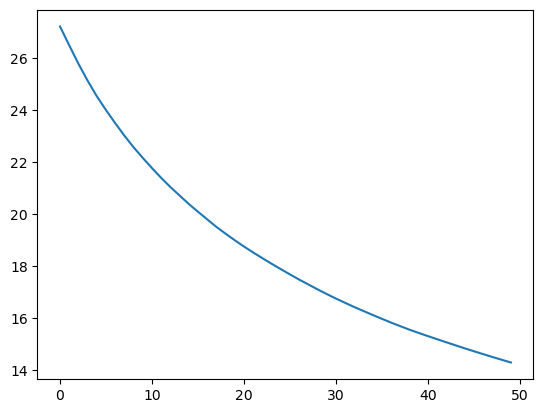

In [61]:
import matplotlib.pyplot as plt

plt.plot(dst)

In [56]:
space_needle_res = estimate.estimate_relation_operator(
    model,
    tokenizer,
    "The Space Needle",
    "{} is located in the country of",
    layer=25,
    device=model.device,
    consider_residual=True, approximate_rank = 1
)

approximation error ==> 46.80177688598633
